<a href="https://colab.research.google.com/github/harish029y/Deep-Learning-for-Galaxy-Classification/blob/main/Deep_Learning_for_Galaxy_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Define initial packages

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [ ]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

In [ ]:
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False) # + [3] for RGB


# don't train existing weights
for layer in vgg.layers:
    layer.trainable = False

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
#Import data
from google.colab import files
uploaded = files.upload()

Saving Galaxy image.zip to Galaxy image.zip


In [ ]:
# Extracting data
import zipfile
import io
data = zipfile.ZipFile(io.BytesIO(uploaded['Galaxy image.zip']), 'r')
data.extractall()

In [ ]:
# useful for getting number of classes
folders = glob('Galaxy image/Data/*')

folders

len(folders)

3

In [ ]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)

class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(x)
prediction = Dense(len(folders), activation='sigmoid')(class1)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
# tell the model what cost and optimization method to use
from keras.optimizers import SGD
opt = SGD(lr=0.001, momentum=0.9)

model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

val_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
training_set = train_datagen.flow_from_directory('Galaxy image/Data/Training',
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

val_set = val_datagen.flow_from_directory('Galaxy image/Data/Validation',
                                            target_size = (224, 224),
                                            batch_size = 64,
                                            class_mode = 'categorical')

Found 7079 images belonging to 3 classes.
Found 743 images belonging to 3 classes.


In [ ]:
training_set.class_indices
val_set.class_indices

{'elliptical': 0, 'irregular': 1, 'spiral': 2}

In [ ]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

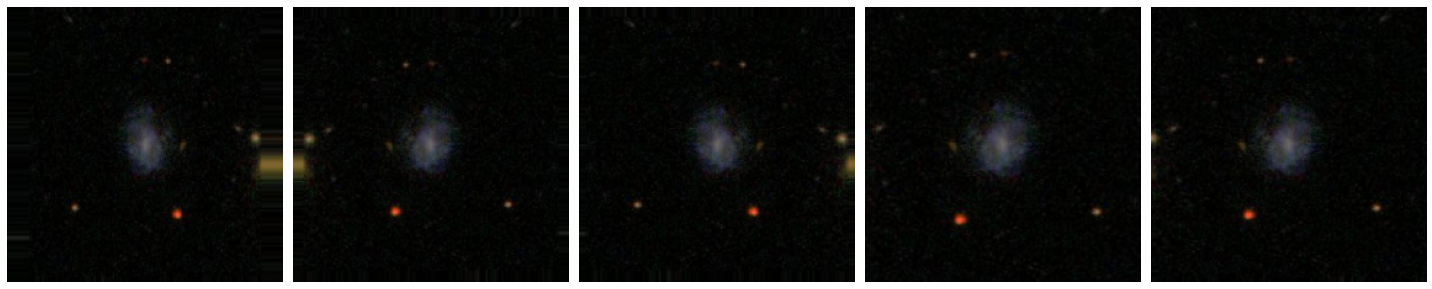

In [ ]:
augmented_images = [training_set[5][0][0] for i in range(5)]
plotImages(augmented_images)

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=75, verbose=1, mode='auto')
hist = model.fit(training_set, validation_data=val_set, epochs=100, steps_per_epoch=len(training_set), validation_steps=len(val_set), callbacks=[checkpoint,early])

Streaming output truncated to the last 5000 lines.
111/111 [==============================] - 96s 861ms/step - loss: 0.2790 - accuracy: 0.8859 - val_loss: 0.2147 - val_accuracy: 0.9287
Epoch 58/100
111/111 [==============================] - 95s 859ms/step - loss: 0.2682 - accuracy: 0.8995 - val_loss: 0.3142 - val_accuracy: 0.8762
Epoch 59/100
111/111 [==============================] - 97s 874ms/step - loss: 0.2944 - accuracy: 0.8859 - val_loss: 0.2142 - val_accuracy: 0.9314
Epoch 60/100
111/111 [==============================] - 96s 864ms/step - loss: 0.2879 - accuracy: 0.8833 - val_loss: 0.2433 - val_accuracy: 0.9112
Epoch 61/100
111/111 [==============================] - 97s 869ms/step - loss: 0.3099 - accuracy: 0.8820 - val_loss: 0.2878 - val_accuracy: 0.9017
Epoch 62/100
111/111 [==============================] - 97s 870ms/step - loss: 0.2705 - accuracy: 0.8964 - val_loss: 0.2422 - val_accuracy: 0.9166
Epoch 63/100
111/111 [==============================] - 95s 858ms/step - loss: 0

In [ ]:
# Saving our model
model.save('model_vgg16_1.h5')

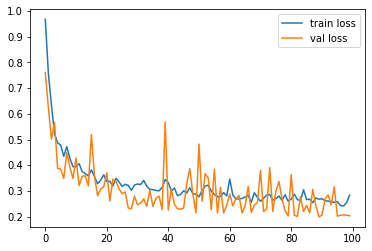

<Figure size 432x288 with 0 Axes>

In [ ]:
# loss
plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

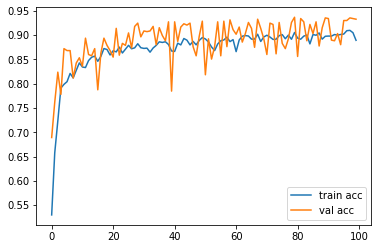

<Figure size 432x288 with 0 Axes>

In [ ]:
# accuracies
plt.plot(hist.history['accuracy'], label='train acc')
plt.plot(hist.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
#Evaluate the accuracy

y = model.evaluate(training_set, verbose=0)
print("Training Accuracy: %.2f" % (y[1]*100))

y = model.evaluate(val_set, verbose=0)
print("Validation Accuracy: %.2f" % (y[1]*100))

Training Accuracy: 90.83
Validation Accuracy: 93.27


1.0

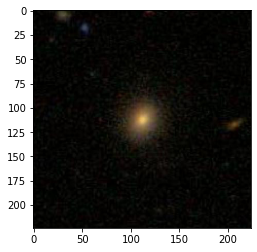

In [ ]:
img = image.load_img('Galaxy image/Data/Training/elliptical/117805.jpg', target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
img_data = preprocess_input(x)
classes = model.predict(img_data)

plt.imshow(img)

classes[0][0]

0.99998975

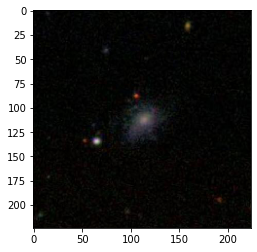

In [ ]:
img = image.load_img('Galaxy image/Data/Training/irregular/115525.jpg', target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
img_data = preprocess_input(x)
classes = model.predict(img_data)

plt.imshow(img)

classes[0][0]

1.0

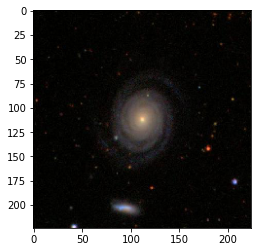

In [ ]:
img = image.load_img('Galaxy image/Data/Training/spiral/105497.jpg', target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
img_data = preprocess_input(x)
classes = model.predict(img_data)

plt.imshow(img)

classes[0][0]

Testing our model with new data:-

[[1.0000000e+00 0.0000000e+00 3.6518928e-16]]


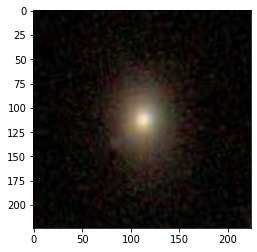

In [ ]:
img_pred = image.load_img("Galaxy image/Data/Testing/464873.jpg", target_size = (224,224))
x = image.img_to_array(img_pred)
x = np.expand_dims(x, axis=0)
img_data = preprocess_input(x)
classes = model.predict(img_data)

plt.imshow(img_pred)

img_pred = image.img_to_array(img_pred)
img_pred = np.expand_dims(img_pred, axis=0)

rslt = model.predict(img_pred)
print(rslt)

[[9.8680425e-25 6.6399169e-10 1.0000000e+00]]


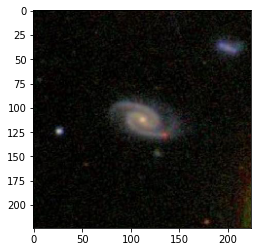

In [ ]:
img_pred = image.load_img("Galaxy image/Data/Testing/330328.jpg", target_size = (224,224))
x = image.img_to_array(img_pred)
x = np.expand_dims(x, axis=0)
img_data = preprocess_input(x)
classes = model.predict(img_data)

plt.imshow(img_pred)

img_pred = image.img_to_array(img_pred)
img_pred = np.expand_dims(img_pred, axis=0)

rslt = model.predict(img_pred)
print(rslt)

[7.130622e-13 9.244241e-01 0.000000e+00]


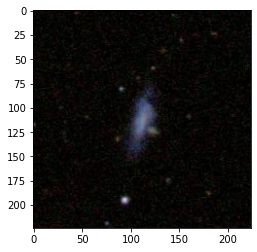

In [ ]:
img_pred = image.load_img("Galaxy image/Data/Testing/834871.jpg", target_size = (224,224)) ## Load image from data
x = image.img_to_array(img_pred)  ## Convert images to array type
x = np.expand_dims(x, axis=0)     ## Convert into numpy 
img_data = preprocess_input(x)    
classes = model.predict(img_data)

plt.imshow(img_pred)

img_pred = image.img_to_array(img_pred)
img_pred = np.expand_dims(img_pred, axis=0)

rslt = model.predict(img_pred)
print(rslt)

In [ ]:
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model

from google.colab import files
uploaded = files.upload()

import zipfile
import io
data = zipfile.ZipFile(io.BytesIO(uploaded['Testing.zip']), 'a')
data.extractall()

Saving Testing.zip to Testing.zip


In [ ]:
!unzip Testing.zip

Archive:  Testing.zip
replace Testing/elliptical/115854.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Testing/elliptical/115854.jpg  
  inflating: Testing/elliptical/175356.jpg  
  inflating: Testing/elliptical/200298.jpg  
  inflating: Testing/elliptical/215766.jpg  
  inflating: Testing/elliptical/217764.jpg  
  inflating: Testing/elliptical/223881.jpg  
  inflating: Testing/elliptical/240294.jpg  
  inflating: Testing/elliptical/245051.jpg  
  inflating: Testing/elliptical/245776.jpg  
  inflating: Testing/elliptical/249060.jpg  
  inflating: Testing/elliptical/268207.jpg  
  inflating: Testing/elliptical/275773.jpg  
  inflating: Testing/elliptical/292854.jpg  
  inflating: Testing/elliptical/308001.jpg  
  inflating: Testing/elliptical/312948.jpg  
  inflating: Testing/elliptical/334836.jpg  
  inflating: Testing/elliptical/335608.jpg  
  inflating: Testing/elliptical/373280.jpg  
  inflating: Testing/elliptical/428198.jpg  
  inflating: Testing/elliptical/466867.jpg  

In [ ]:
test_set = ImageDataGenerator(rescale = 1./255).flow_from_directory('Testing', target_size=(224,224), batch_size=3)

y = model.evaluate(test_set, verbose=0)
print("Testing Accuracy: %.2f" % (y[1]*100))

Found 100 images belonging to 3 classes.
Testing Accuracy: 99.00


In [ ]:
import numpy as np
predictions = model.predict(x=test_set, steps=len(test_set), verbose=0)
np.round(predictions)

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true=test_set.classes, y_pred=np.argmax(predictions, axis=-1))
test_set.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [ ]:
np.argmax(predictions, axis=-1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2])

In [ ]:
# defining the confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text( j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
test_set.class_indices

{'elliptical': 0, 'irregular': 1, 'spiral': 2}

In [ ]:
import itertools
cm_plot_labels = ['elliptical','irregular', 'spiral']

Confusion matrix, without normalization
[[34  1  0]
 [ 1 27  2]
 [ 1  3 31]]


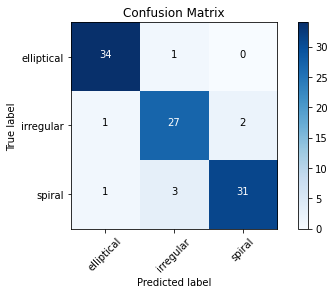

In [ ]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')